In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import time

In [3]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)
    
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    # Use c = y to color each point
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    #plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)
    
def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

def plot_model2(X, y, model, r2 = 5, step = 10):
    """
    Plot the subdomain partition predicted by the neuaral network
    """
    model.cpu()
    mesh = np.arange(-r2 -0.5, r2 + 0.5, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    # Plot the sample points of each subdomain
    # plt.scatter(X.numpy()[:-1:step, 0], X.numpy()[:-1:step, 1], c=y[:-1:step], s=20, cmap=plt.cm.Spectral)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.title('Predicted domain partiton')

In [4]:
set_default()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\abhil\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

# Input parameters.
N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10 # number of neuros of the fourth hidden layer
noice = 0.5 # noice rate

# Allocation of the memories 
#  X: a 2D array for the matrix of order NC x D
#  y: a 1D array for the vector of order NC
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

# Generate a uniform partition of interval [0, 1] for parameter variable t
#  t_j = j/N for j=0, 1, 2, ..., N
t = torch.linspace(0, 1, N)

# Length of each subinterval 
tau = 2* math.pi/C

In [6]:
X[1499]

tensor([0., 0.])

In [7]:
r=0.3
r2=0.5
n = int(N/2)
n

250

# Ring with radii r1 and r2

In [8]:
for i in range(C):  # Here i = 0, 1, 2, ..., C-1
    j = 0
    # Generate N numbers in the subinterval [tau*i, tau*(i+1)] with tau = 2pi/C
    theta = torch.linspace(tau * i, tau * (i + 1), N) + torch.randn(N) * noice
   
    # Generate the N sample points in the $i$th subdomain D_i
   
        
    for ix in range(n * i, n * (i + 1)):
        X[ix] = torch.FloatTensor((
            r*math.sin(theta[j]), r*math.cos(theta[j])
        ))
        y[ix] = i
        j += 1
        
    for ix in range(n * i+750, n * (i + 1)+750):
        X[ix] = torch.FloatTensor((
            r2*math.sin(theta[j]), r2*math.cos(theta[j])
        ))
        y[ix] = i
        j += 1
      
          

        
  
        
 
    

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))
#print('y=', y)
#print('X=', X)

Shapes:
X: (1500, 2)
y: (1500,)


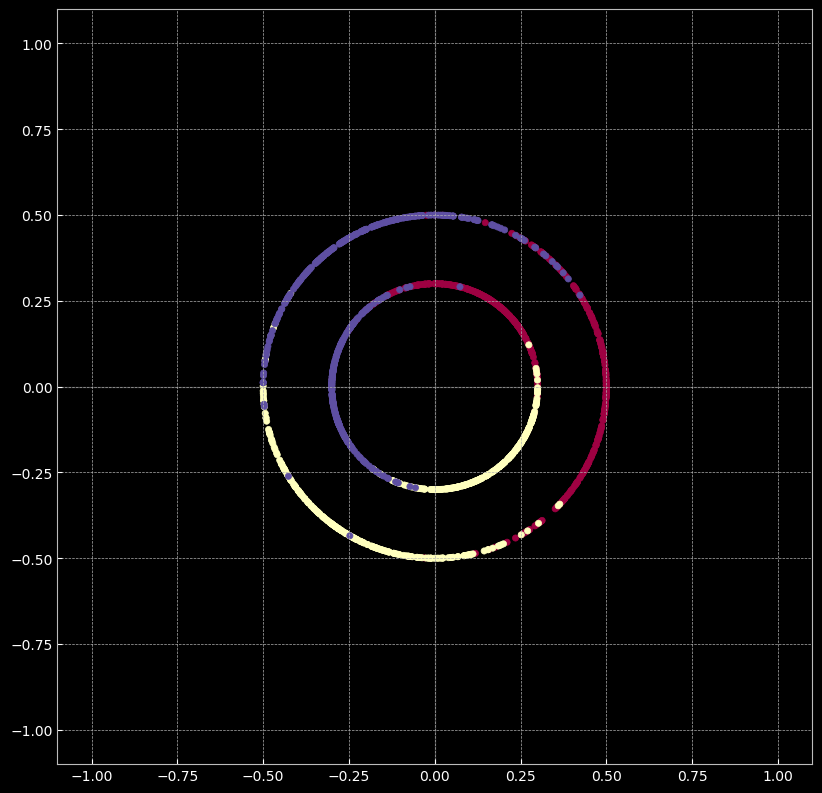

In [9]:
plot_data(X, y)

In [10]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [11]:
# nn package to create our linear model
# each Linear module has a weight and bias
linear_model = nn.Sequential(
    nn.Linear(D, H1),
    nn.Linear(H1, H2),
    nn.Linear(H2, H3),
    nn.Linear(H3, C)
)
linear_model.to(device) #Convert to CUDA

# nn package has different loss functions.
# We can use the Mean Squared Error Loss Function: 
#     Loss = torch.nn.MSELoss()
#  or use the cross entropy loss function:
#     Loss = torch.nn.CrossEntropyLoss()

#Loss = torch.nn.MSELoss()
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = linear_model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 1.084271, [ACCURACY]: 0.566


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Linear(in_features=10, out_features=3, bias=True)
)


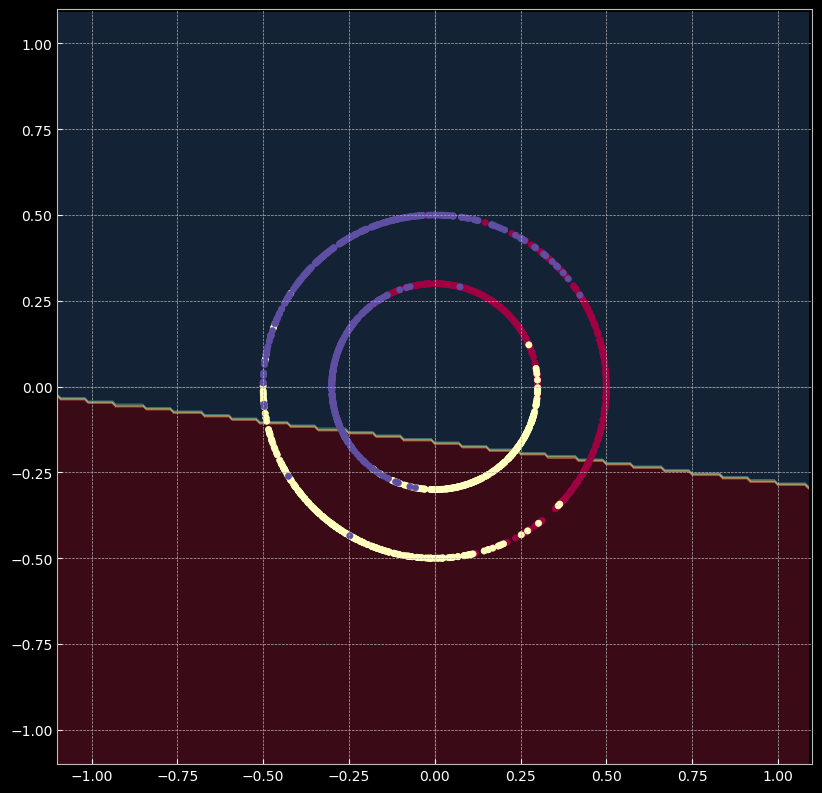

In [12]:
print(linear_model)
plot_model(X, y, linear_model)

In [13]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model = nn.Sequential(
    nn.Linear(D, H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.ReLU(),
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.102108, [ACCURACY]: 0.242
[EPOCH]: 1, [LOSS]: 1.096131, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.065827, [ACCURACY]: 0.496
[EPOCH]: 3, [LOSS]: 0.978373, [ACCURACY]: 0.768
[EPOCH]: 4, [LOSS]: 0.845409, [ACCURACY]: 0.783
[EPOCH]: 5, [LOSS]: 0.692413, [ACCURACY]: 0.706
[EPOCH]: 6, [LOSS]: 0.608899, [ACCURACY]: 0.728
[EPOCH]: 7, [LOSS]: 0.581527, [ACCURACY]: 0.793
[EPOCH]: 8, [LOSS]: 0.579424, [ACCURACY]: 0.792
[EPOCH]: 9, [LOSS]: 0.525809, [ACCURACY]: 0.789
[EPOCH]: 10, [LOSS]: 0.565723, [ACCURACY]: 0.786
[EPOCH]: 11, [LOSS]: 0.510869, [ACCURACY]: 0.807
[EPOCH]: 12, [LOSS]: 0.533734, [ACCURACY]: 0.797
[EPOCH]: 13, [LOSS]: 0.505481, [ACCURACY]: 0.803
[EPOCH]: 14, [LOSS]: 0.483837, [ACCURACY]: 0.793
[EPOCH]: 15, [LOSS]: 0.481541, [ACCURACY]: 0.805
[EPOCH]: 16, [LOSS]: 0.463112, [ACCURACY]: 0.805
[EPOCH]: 17, [LOSS]: 0.440641, [ACCURACY]: 0.811
[EPOCH]: 18, [LOSS]: 0.455299, [ACCURACY]: 0.807
[EPOCH]: 19, [LOSS]: 0.427287, [ACCURACY]: 0.821
[EPOCH]: 20, [LOSS]: 0.441741,

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=3, bias=True)
)


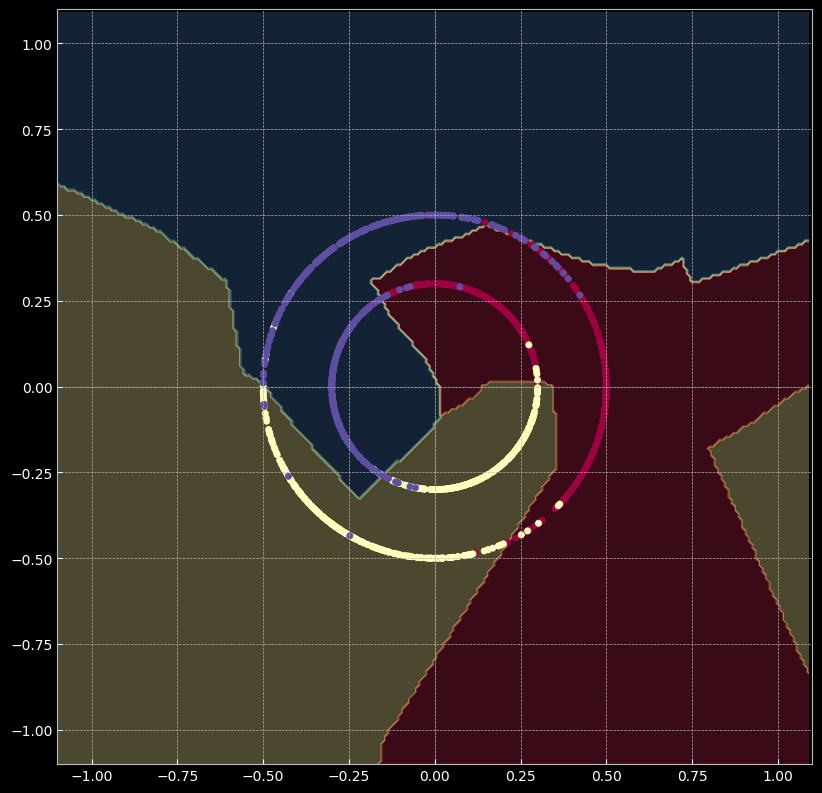

In [14]:
print(model)
plot_model(X, y, model)

# Network with 3 hidden layers

In [476]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model3 = nn.Sequential(
    nn.Linear(D, H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.ReLU(),
    nn.Linear(H3, H4),
    nn.ReLU(),
    nn.Linear(H4, C)
)
model3.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model3(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.103265, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.102433, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.101435, [ACCURACY]: 0.333
[EPOCH]: 3, [LOSS]: 1.094989, [ACCURACY]: 0.333
[EPOCH]: 4, [LOSS]: 1.081785, [ACCURACY]: 0.333
[EPOCH]: 5, [LOSS]: 1.054489, [ACCURACY]: 0.587
[EPOCH]: 6, [LOSS]: 0.991360, [ACCURACY]: 0.555
[EPOCH]: 7, [LOSS]: 0.937218, [ACCURACY]: 0.576
[EPOCH]: 8, [LOSS]: 0.912236, [ACCURACY]: 0.601
[EPOCH]: 9, [LOSS]: 0.883178, [ACCURACY]: 0.597
[EPOCH]: 10, [LOSS]: 0.841081, [ACCURACY]: 0.599
[EPOCH]: 11, [LOSS]: 0.834471, [ACCURACY]: 0.585
[EPOCH]: 12, [LOSS]: 0.829182, [ACCURACY]: 0.587
[EPOCH]: 13, [LOSS]: 0.808133, [ACCURACY]: 0.590
[EPOCH]: 14, [LOSS]: 0.797387, [ACCURACY]: 0.597
[EPOCH]: 15, [LOSS]: 0.782475, [ACCURACY]: 0.603
[EPOCH]: 16, [LOSS]: 0.782446, [ACCURACY]: 0.607
[EPOCH]: 17, [LOSS]: 0.770374, [ACCURACY]: 0.611
[EPOCH]: 18, [LOSS]: 0.757605, [ACCURACY]: 0.623
[EPOCH]: 19, [LOSS]: 0.745764, [ACCURACY]: 0.635
[EPOCH]: 20, [LOSS]: 0.739363,

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=3, bias=True)
)


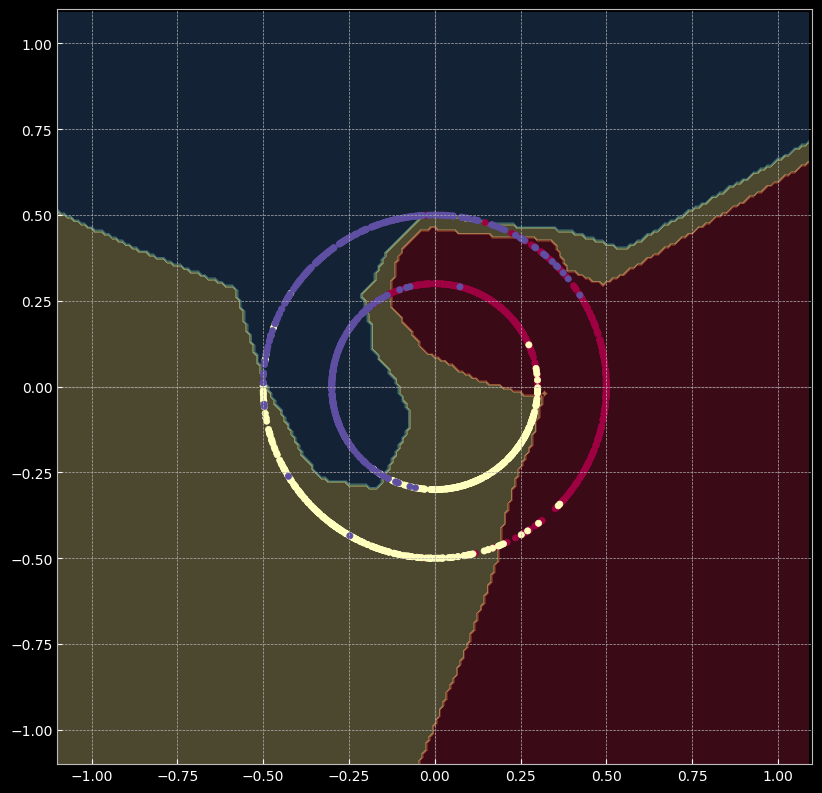

In [477]:
print(model3)
plot_model(X, y, model3)

# Number of neurons

In [478]:
h1 = 50  # number of neuros of the first hidden layer
h2 = 25  # number of neuros of the second hidden layer
h3 = 25  # number of neuros of the third hidden layer
h4 = 10 # number of neuros of the fourth hidden layer

In [479]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model4 = nn.Sequential(
    nn.Linear(D, h1),
    nn.ReLU(),
    nn.Linear(h1, h2),
    nn.ReLU(),
    nn.Linear(h2, h3),
    nn.ReLU(),
    nn.Linear(h3, h4),
    nn.ReLU(),
    nn.Linear(h4, C)
)
model4.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model4(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.105202, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.339078, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.096579, [ACCURACY]: 0.333
[EPOCH]: 3, [LOSS]: 1.082613, [ACCURACY]: 0.333
[EPOCH]: 4, [LOSS]: 1.025293, [ACCURACY]: 0.421
[EPOCH]: 5, [LOSS]: 0.959693, [ACCURACY]: 0.397
[EPOCH]: 6, [LOSS]: 0.871276, [ACCURACY]: 0.636
[EPOCH]: 7, [LOSS]: 0.840177, [ACCURACY]: 0.631
[EPOCH]: 8, [LOSS]: 0.825782, [ACCURACY]: 0.629
[EPOCH]: 9, [LOSS]: 0.806896, [ACCURACY]: 0.645
[EPOCH]: 10, [LOSS]: 0.772290, [ACCURACY]: 0.646
[EPOCH]: 11, [LOSS]: 0.735209, [ACCURACY]: 0.661
[EPOCH]: 12, [LOSS]: 0.705659, [ACCURACY]: 0.692
[EPOCH]: 13, [LOSS]: 0.689152, [ACCURACY]: 0.655
[EPOCH]: 14, [LOSS]: 0.673323, [ACCURACY]: 0.707
[EPOCH]: 15, [LOSS]: 0.605788, [ACCURACY]: 0.760
[EPOCH]: 16, [LOSS]: 0.581930, [ACCURACY]: 0.786
[EPOCH]: 17, [LOSS]: 0.540641, [ACCURACY]: 0.798
[EPOCH]: 18, [LOSS]: 0.576091, [ACCURACY]: 0.797
[EPOCH]: 19, [LOSS]: 0.554578, [ACCURACY]: 0.798
[EPOCH]: 20, [LOSS]: 0.707678,

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=3, bias=True)
)


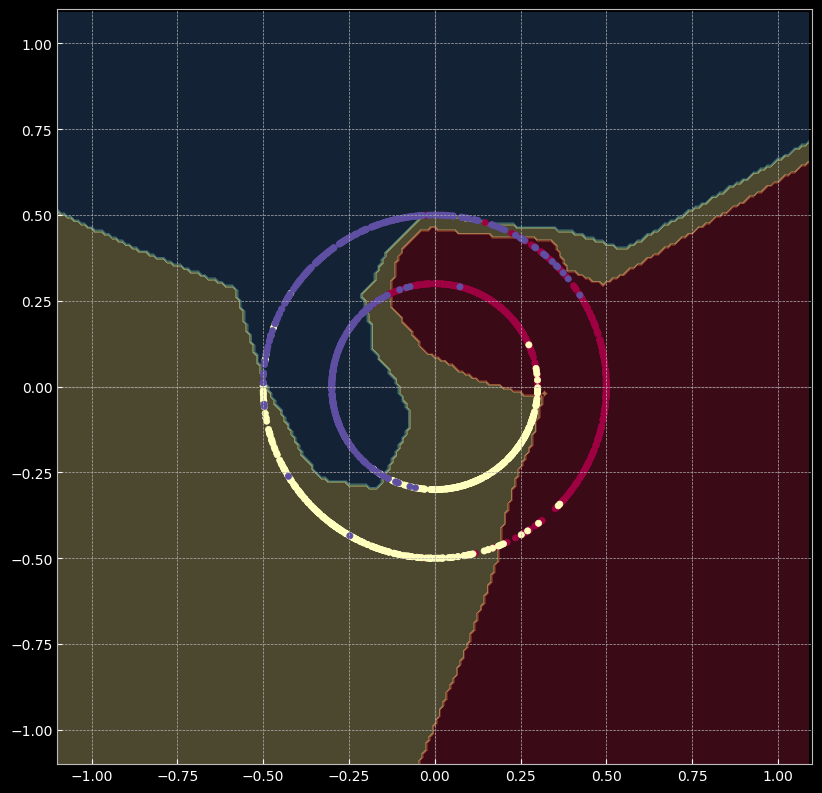

In [480]:
print(model3)
plot_model(X, y, model3)

# Different activation function

In [481]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model5 = nn.Sequential(
    nn.Linear(D, h1),
    nn.LeakyReLU(),
    nn.Linear(h1, h2),
    nn.LeakyReLU(),
    nn.Linear(h2, h3),
    nn.LeakyReLU(),
    nn.Linear(h3, h4),
    nn.LeakyReLU(),
    nn.Linear(h4, C)
)
model5.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model5(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.101817, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.135709, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.111342, [ACCURACY]: 0.333
[EPOCH]: 3, [LOSS]: 1.194819, [ACCURACY]: 0.333
[EPOCH]: 4, [LOSS]: 1.080574, [ACCURACY]: 0.333
[EPOCH]: 5, [LOSS]: 1.048458, [ACCURACY]: 0.606
[EPOCH]: 6, [LOSS]: 0.967242, [ACCURACY]: 0.453
[EPOCH]: 7, [LOSS]: 1.211015, [ACCURACY]: 0.491
[EPOCH]: 8, [LOSS]: 0.804113, [ACCURACY]: 0.789
[EPOCH]: 9, [LOSS]: 0.826933, [ACCURACY]: 0.740
[EPOCH]: 10, [LOSS]: 0.720287, [ACCURACY]: 0.786
[EPOCH]: 11, [LOSS]: 0.585370, [ACCURACY]: 0.789
[EPOCH]: 12, [LOSS]: 0.642285, [ACCURACY]: 0.751
[EPOCH]: 13, [LOSS]: 0.655306, [ACCURACY]: 0.778
[EPOCH]: 14, [LOSS]: 0.574656, [ACCURACY]: 0.792
[EPOCH]: 15, [LOSS]: 0.560408, [ACCURACY]: 0.799
[EPOCH]: 16, [LOSS]: 0.502477, [ACCURACY]: 0.820
[EPOCH]: 17, [LOSS]: 0.495958, [ACCURACY]: 0.823
[EPOCH]: 18, [LOSS]: 0.453358, [ACCURACY]: 0.831
[EPOCH]: 19, [LOSS]: 0.455880, [ACCURACY]: 0.824
[EPOCH]: 20, [LOSS]: 0.411818,

Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=25, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=3, bias=True)
)


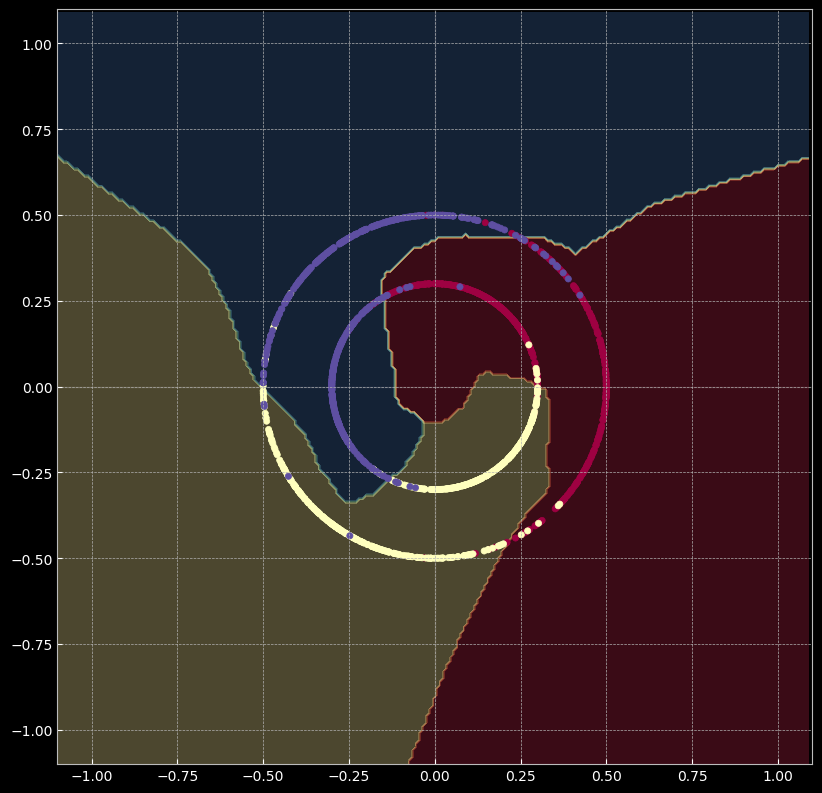

In [482]:
print(model5)
plot_model(X, y, model5)

# SGD loss function

In [483]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
model6 = nn.Sequential(
    nn.Linear(D, h1),
    nn.LeakyReLU(),
    nn.Linear(h1, h2),
    nn.LeakyReLU(),
    nn.Linear(h2, h3),
    nn.LeakyReLU(),
    nn.Linear(h3, h4),
    nn.LeakyReLU(),
    nn.Linear(h4, C)
)
model6.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
optimizer = torch.optim.SGD(model6.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
#optimizer = torch.optim.Adam(model6.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model6(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

[EPOCH]: 0, [LOSS]: 1.102290, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.101621, [ACCURACY]: 0.333
[EPOCH]: 2, [LOSS]: 1.101074, [ACCURACY]: 0.333
[EPOCH]: 3, [LOSS]: 1.100581, [ACCURACY]: 0.333
[EPOCH]: 4, [LOSS]: 1.100130, [ACCURACY]: 0.333
[EPOCH]: 5, [LOSS]: 1.099699, [ACCURACY]: 0.333
[EPOCH]: 6, [LOSS]: 1.099291, [ACCURACY]: 0.333
[EPOCH]: 7, [LOSS]: 1.098899, [ACCURACY]: 0.333
[EPOCH]: 8, [LOSS]: 1.098525, [ACCURACY]: 0.333
[EPOCH]: 9, [LOSS]: 1.098165, [ACCURACY]: 0.333
[EPOCH]: 10, [LOSS]: 1.097820, [ACCURACY]: 0.333
[EPOCH]: 11, [LOSS]: 1.097485, [ACCURACY]: 0.333
[EPOCH]: 12, [LOSS]: 1.097159, [ACCURACY]: 0.333
[EPOCH]: 13, [LOSS]: 1.096843, [ACCURACY]: 0.333
[EPOCH]: 14, [LOSS]: 1.096533, [ACCURACY]: 0.333
[EPOCH]: 15, [LOSS]: 1.096229, [ACCURACY]: 0.333
[EPOCH]: 16, [LOSS]: 1.095931, [ACCURACY]: 0.333
[EPOCH]: 17, [LOSS]: 1.095608, [ACCURACY]: 0.333
[EPOCH]: 18, [LOSS]: 1.095237, [ACCURACY]: 0.333
[EPOCH]: 19, [LOSS]: 1.094855, [ACCURACY]: 0.333
[EPOCH]: 20, [LOSS]: 1.094467,

Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=25, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=3, bias=True)
)


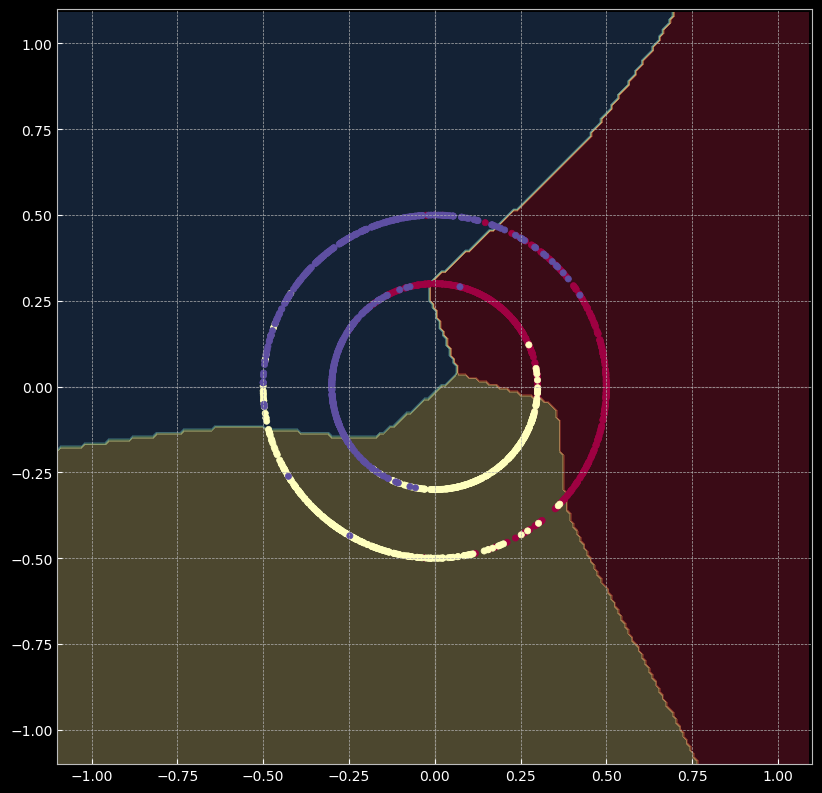

In [484]:
print(model6)
plot_model(X, y, model6)